## Creating a CNN in Python

The MNIST dataset is used for this example, but can be extended to any model.

In [3]:
import torch
import os
import torchvision
from PIL import Image

# The dataset should be in a directory where the folder names is the label. 
# This function computes it for PyTorch
def labelled_dataset(dataset, path):
    for i in range(len(dataset)):
        image, label = dataset[i]
        image = torchvision.transforms.ToPILImage()(image)
        directory = f"{path}/{label}"
        if not os.path.exists(directory):
            os.makedirs(directory)
        image.save(f"{directory}/{i}.png")
        

In [4]:
# Download the MNIST train
train_path = "dataset/train"
train = torchvision.datasets.MNIST(
    root=train_path,
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)

labelled_dataset(train, train_path)

In [5]:
# Download the MNIST validation
val_path = "dataset/validation"
validation = torchvision.datasets.MNIST(
    root=val_path,
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)

labelled_dataset(validation, val_path)

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:04<00:00, 2173822.13it/s]


Extracting dataset/validation/MNIST/raw/train-images-idx3-ubyte.gz to dataset/validation/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 28881/28881 [00:00<00:00, 135088.59it/s]


Extracting dataset/validation/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/validation/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:01<00:00, 1245518.13it/s]


Extracting dataset/validation/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/validation/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 4542/4542 [00:00<00:00, 7500208.18it/s]


Extracting dataset/validation/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/validation/MNIST/raw



In [6]:
print(f"Number of Training Images: {len(train)}")
print(f"Number of Validation Images: {len(validation)}")

Number of Training Images: 60000
Number of Validation Images: 10000


In [7]:
# Remove the MNIST folder from both train and vdaliation
os.system(f"rm -r {train_path}/MNIST")
os.system(f"rm -r {val_path}/MNIST")

0

In [8]:
# Configure device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cpu')

In [11]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

batch_size = 32

# # Create the DataLoader
training_data = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=4)
validation_data = DataLoader(validation, batch_size=batch_size, shuffle=True, num_workers=4)

In [30]:
# Define the NN model
from torch import nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # --- Define Conv Part
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.linear_block = nn.Sequential(
            nn.Linear(10*14*14, 10)
        )
        
    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        return x

In [31]:
cnn = CNN().to(device)
cnn

CNN(
  (conv_block): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Linear(in_features=1960, out_features=10, bias=True)
  )
)

In [32]:
# Create optimiser and loss function. Use Adam.

from torch import optim

lr = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=lr)

In [41]:
# Training loop
epochs = 5
losses = []


for epoch in range(epochs):
    for i, (images, labels) in enumerate(training_data):
        image, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = cnn(image)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        
        if (i+1) % 1000 == 0:
            print(f"Epoch: {epoch+1}/{epochs}, Step: {i+1}, Loss: {loss.item()}")
        
        if (i+1) % 100 == 0:
            losses.append(loss.item())
            

Epoch: 1/5, Step: 1000, Loss: 0.04405318945646286
Epoch: 2/5, Step: 1000, Loss: 0.049607645720243454
Epoch: 3/5, Step: 1000, Loss: 0.00906305480748415
Epoch: 4/5, Step: 1000, Loss: 0.0542774423956871
Epoch: 5/5, Step: 1000, Loss: 0.10073570907115936


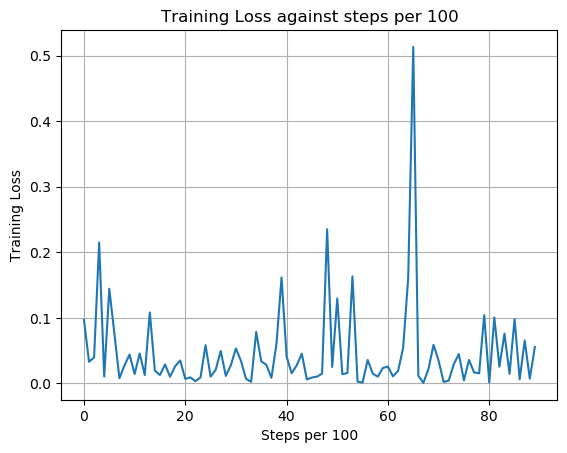

In [62]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.grid()
plt.title("Training Loss against steps per 100")
plt.xlabel("Steps per 100")
plt.ylabel("Training Loss")
plt.show()

In [45]:
# Validate

cnn.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in validation_data:
        images, labels = images.to(device), labels.to(device)
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total}")

Accuracy: 98.12


Prediction: 4, True Label: 4


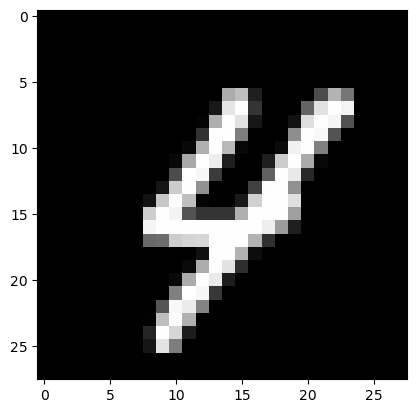

In [60]:
# Select a random index to see the image and what it predicts

import random

index = random.randint(0, len(validation_data.dataset))
image, label = validation_data.dataset[index]

image = image.unsqueeze(0).to(device)

plt.imshow(image.cpu().numpy().squeeze(), cmap="gray")

output = cnn(image)
print(f"Prediction: {output.argmax().item()}, True Label: {label}")

In [61]:
# Save the model
torch.save(cnn.state_dict(), "models/mnist.pth")

In [65]:
# Extract parameters
from torch import onnx

%pip install onnx
onnx.export(cnn, image, "models/mnist.onnx", 
    input_names=["input"], output_names=["output"],
    verbose=True)


     |████████████████████████████████| 15.9 MB 85 kB/s s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.
Exported graph: graph(%input : Float(1, 1, 28, 28, strides=[1, 1, 28, 1], requires_grad=0, device=cpu),
      %conv_block.0.weight : Float(10, 1, 3, 3, strides=[9, 9, 3, 1], requires_grad=1, device=cpu),
      %conv_block.0.bias : Float(10, strides=[1], requires_grad=1, device=cpu),
      %linear_block.0.weight : Float(10, 1960, strides=[1960, 1], requires_grad=1, device=cpu),
      %linear_block.0.bias : Float(10, strides=[1], requires_grad=1, device=cpu)):
  %/conv_block/conv_block.0/Conv_output_0 : Float(1, 10, 28, 28, strides=[7840, 784, 28, 1], requires_grad=0, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1], onnx_name="/conv_block/conv_block.0/Conv"](%input, %conv_block.0.weight, %conv_block.0.bias), scope: __main__.CNN::/torch.nn.modules.container.Sequential::conv_block/torch.nn.modules.

In [68]:
# Check the model
import onnx

onnx_model = onnx.load("models/mnist.onnx")
onnx.checker.check_model(onnx_model)

print(onnx_model)

ir_version: 7
opset_import {
  version: 14
}
producer_name: "pytorch"
producer_version: "2.0.0"
graph {
  node {
    input: "input"
    input: "conv_block.0.weight"
    input: "conv_block.0.bias"
    output: "/conv_block/conv_block.0/Conv_output_0"
    name: "/conv_block/conv_block.0/Conv"
    op_type: "Conv"
    attribute {
      name: "dilations"
      type: INTS
      ints: 1
      ints: 1
    }
    attribute {
      name: "group"
      type: INT
      i: 1
    }
    attribute {
      name: "kernel_shape"
      type: INTS
      ints: 3
      ints: 3
    }
    attribute {
      name: "pads"
      type: INTS
      ints: 1
      ints: 1
      ints: 1
      ints: 1
    }
    attribute {
      name: "strides"
      type: INTS
      ints: 1
      ints: 1
    }
    doc_string: "/home/josh/.local/lib/python3.8/site-packages/torch/nn/modules/conv.py(459): _conv_forward\n/home/josh/.local/lib/python3.8/site-packages/torch/nn/modules/conv.py(463): forward\n/home/josh/.local/lib/python3.8/site-

In [71]:
# Retrieve only the nodes of the graph

INTIALIZERS  = onnx_model.graph.initializer
nodes=onnx_model.graph.node
onnx_weights = {}
for initializer in INTIALIZERS:
    W = onnx.numpy_helper.to_array(initializer)
    onnx_weights[initializer.name] = W

print(onnx_weights.keys())

dict_keys(['conv_block.0.weight', 'conv_block.0.bias', 'linear_block.0.weight', 'linear_block.0.bias'])


We use the above key-value pair to generate a `.txt` file that contains the model weights. This can then be loaded in to the hardware accelerator and used to replace generic parameters.

It should be separated again into a printable format. The desired structure is:

```txt
# Comment
weights
bias

weights
bias
```

The weights and bias are separated by a newline character. The weights are separated by a space character. EOF indicates end of file. Comments should use Python syntax as #, indicating they are ignored.

For this to be better implemented, the dictionary should be keyed by another layer to indicate `layer_name` and then keyed to it's weights and biases. Hence:

In [89]:
# Restructure the format
onnx_structure = dict()
for i in range(0, len(onnx_weights.keys()), 2):
    original = list(onnx_weights.keys())[i]
    key_parts = original.split('.')
    key = '_'.join(key_parts[:2])  # Keep only the first two parts
    onnx_structure[key] = {
        'weight': onnx_weights[original],
        'bias': onnx_weights[list(onnx_weights.keys())[i+1]]
    }
print(onnx_structure.keys())

dict_keys(['conv_block_0', 'linear_block_0'])


In [95]:
# Check the internals of the structure and verify the shapes

print(onnx_structure['conv_block_0']['weight'].shape)
print(onnx_structure['conv_block_0']['bias'].shape)

print(onnx_structure['linear_block_0']['weight'].shape)
print(onnx_structure['linear_block_0']['bias'].shape)



(10, 1, 3, 3)
(10,)
(10, 1960)
(10,)
